In [ ]:
# https://poddeeplearning.readthedocs.io/ko/latest/CNN/VGG19%20+%20GAP%20+%20CAM/ 참조

In [1]:
from google.colab import drive
drive.mount('vggnet')

Mounted at vggnet


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

In [9]:
# STL10 dataset 사용
# 이미지 데어터 전처리
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


 bird   dog plane plane


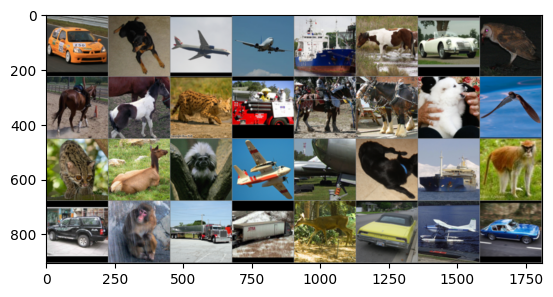

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
# Modeling
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.conv = nn.Sequential(
            # Size 3 224 128
            nn.Conv2d(3, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            # Size 64 112 64
            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            # Size 128 56 32
            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            # Size 256 28 16
            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            # Size 512 14 8
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
        # Size 512 7 4

        self.avg_pool = nn.AvgPool2d(7)
        # Size 512 1 1
        self.classifier = nn.Linear(512, 10)
        """
        self.fc1 = nn.Linear(512*2*2,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,10)
        """

    def forward(self, x):
        features = self.conv(x)
        x = self.avg_pool(features)
        x = x.view(features.size(0), -1)
        x = self.classifier(x)
        return x, features

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vggnet = VGGNet()
vggnet = vggnet.to(device)
param = list(vggnet.parameters())
print(len(param))
for i in param:
    print(i.shape)

28
torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [21]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(vggnet.parameters(),lr=0.0001)

In [25]:
# Training
for epoch in range(20):  # epoch 20
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # gradient 초기화
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs,f = vggnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if(loss.item() > 1000):
            print(loss.item())
            for param in vggnet.parameters():
                print(param.data)
        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 1.687
[1,   100] loss: 1.648
[1,   150] loss: 1.665
[2,    50] loss: 1.613
[2,   100] loss: 1.585
[2,   150] loss: 1.582
[3,    50] loss: 1.540
[3,   100] loss: 1.532
[3,   150] loss: 1.551
[4,    50] loss: 1.471
[4,   100] loss: 1.461
[4,   150] loss: 1.492
[5,    50] loss: 1.418
[5,   100] loss: 1.455
[5,   150] loss: 1.399
[6,    50] loss: 1.367
[6,   100] loss: 1.415
[6,   150] loss: 1.328
[7,    50] loss: 1.300
[7,   100] loss: 1.311
[7,   150] loss: 1.380
[8,    50] loss: 1.318
[8,   100] loss: 1.307
[8,   150] loss: 1.248
[9,    50] loss: 1.297
[9,   100] loss: 1.276
[9,   150] loss: 1.254
[10,    50] loss: 1.158
[10,   100] loss: 1.192
[10,   150] loss: 1.244
[11,    50] loss: 1.167
[11,   100] loss: 1.186
[11,   150] loss: 1.180
[12,    50] loss: 1.147
[12,   100] loss: 1.169
[12,   150] loss: 1.091
[13,    50] loss: 1.021
[13,   100] loss: 1.072
[13,   150] loss: 1.070
[14,    50] loss: 1.024
[14,   100] loss: 1.028
[14,   150] loss: 1.010
[15,    50] loss: 0

In [26]:
# Validation
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs,_ = vggnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 56 %
Accuracy of  bird : 62 %
Accuracy of   cat : 60 %
Accuracy of  deer : 65 %
Accuracy of   dog : 29 %
Accuracy of  frog : 61 %
Accuracy of horse : 62 %
Accuracy of  ship : 87 %
Accuracy of truck : 59 %
